In [2]:
%cd 'drive/My Drive/NASA SpaceApps Challenge'

/content/drive/.shortcut-targets-by-id/106/NASA SpaceApps Challenge


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime, timedelta

2.2.0
                      dt state_name  ...  Total Test Results  % Positive
state county                         ...                                
AL    Autauga 2020-01-22    Alabama  ...                   0        0.00
      Autauga 2020-01-23    Alabama  ...                   0        0.00
      Autauga 2020-01-24    Alabama  ...                   0        0.00
      Autauga 2020-01-25    Alabama  ...                   0        0.00
      Autauga 2020-01-26    Alabama  ...                   0        0.00
...                  ...        ...  ...                 ...         ...
WY    Weston  2020-05-23    Wyoming  ...                 244        4.06
      Weston  2020-05-24    Wyoming  ...                 244        4.06
      Weston  2020-05-25    Wyoming  ...                 249        4.11
      Weston  2020-05-26    Wyoming  ...                 262        3.95
      Weston  2020-05-27    Wyoming  ...                 262        3.95

[394445 rows x 47 columns]
Single window of 

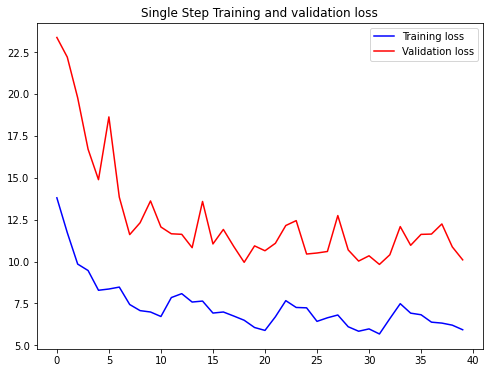

In [37]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print(tf.__version__)
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()

df = pd.read_csv('data/jhu_covid19.csv',parse_dates=['dt'])
df.set_index(['state','county'],inplace=True)

df['ColumnAmountNO2'] = df['ColumnAmountNO2']/1e15
df['ColumnAmountNO2CloudScreened'] = df['ColumnAmountNO2CloudScreened']/1e15

df = df.groupby(['state','county']).bfill().ffill()
df = df.dropna(how='all')
df = df.drop(columns=['# Asian','Unnamed: 0', 'Unnamed: 0.1'])
print(df)

TRAIN_SPLIT = 0.8
BUFFER_SIZE = 10000
BATCH_SIZE = 128
EVALUATION_INTERVAL = 200
EPOCHS = 20

past_history = 14
future_target = 7
STEP = 1

tf.random.set_seed(13)
tf.keras.backend.set_epsilon(1)

target_name = 'Hotspot Index'
growth = df['Confirmed'].subtract(df['NewCases'],fill_value=0)
growth_percentage = df['NewCases']/growth.replace({0:1})

df[target_name] = np.log(df['IncidenceRate']*0.003+df['MortalityRate']*0.003+(growth_percentage*0.002)+np.log(df['Confirmed']+1)*0.002+1)
#df[target_name+'_rank']=df[target_name].rank(method='min')
#df[target_name] = df[target_name].rank(pct=True,method='dense')*10

non_data = ['state_name']
data_considered = [column for column in df.columns if column not in non_data]
counties = df[data_considered].groupby(['state','county'],as_index=False)
#drop = ['Precipitation','ColumnAmountNO2','ColumnAmountNO2CloudScreened']
x_train = []; y_train = []
x_val = []; y_val = []
l = 0

for name,county in counties:
  l += 1
  train_split = int(TRAIN_SPLIT*len(county))

  if(np.any([county[i].isnull().all() for i in data_considered])):
      continue

  
  # Normalize the training data
  county = county.drop(columns=['dt']).values.astype('float')
  
  #county = county[['Deaths','Population',]].values.astype('float')


  x_train_single, y_train_single = multivariate_data(county, county[:,-1], 0,
                                                  train_split, past_history,
                                                  future_target, STEP,
                                                  single_step=True)

  #print(x_train_single,y_train_single)
  x_train.append(x_train_single); y_train.append(y_train_single)

  x_val_single, y_val_single = multivariate_data(county, county[:,-1],
                                              train_split, None, past_history,
                                              future_target, STEP,
                                              single_step=True)
  #print(x_train_single,y_train_single)
  x_val.append(x_val_single); y_val.append(y_val_single)

x_train = np.vstack(x_train); y_train = np.hstack(y_train)
x_val = np.vstack(x_val); y_val = np.hstack(y_val)

# Normalization
county_mean = np.nanmean(x_train,axis=0)
county_std = np.nanstd(x_train,axis=0)
y_mean = np.nanmean(y_train)
y_std = np.nanstd(y_train)

x_train = (x_train - county_mean)/county_std
y_train = (y_train - y_mean)/y_std
x_val = (x_val - county_mean)/county_std
y_val = (y_val-y_mean)/y_std

#county[0] = county[0] + county_mean

# x_train = x_train_single; y_train = y_train_single
# x_val = x_val_single; y_val = y_val_single

print ('Single window of past history : {}'.format(x_train[0].shape))

train_data_single = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

model = tf.keras.models.Sequential()
#model = tf.keras.models.load_model('model_14_7_single.h5')
units = 256
model.add(LSTM(units*2,return_sequences=True,input_shape=x_train.shape[-2:]))
model.add(LSTM(units))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4,clipvalue=1e-5), loss =['mean_absolute_percentage_error'], metrics='mae')
for x, y in val_data_single.take(1):
  print(x.shape,y.shape)
  print(model.predict(x).shape)

single_step_history = model.fit(train_data_single, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data_single,
                                      validation_steps=50)
plot_train_history(single_step_history,'Single Step Training and validation loss')

In [0]:
df.to_csv('jhu_covid19.csv')

In [38]:
d = df[target_name]
d.mean(),d.median(),d.max(),d.min(),d.quantile(0.25),d.quantile(0.75)

(0.1280508929423112,
 0.0,
 4.290562200457387,
 -0.0020020026706730793,
 0.0,
 0.1251095433313128)

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    print(i)
    if i:
      print(x.shape)
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [93]:
eval = model.evaluate(x_val,y_val,batch_size=BATCH_SIZE)
print(eval)
# mape = tf.keras.losses.MeanAbsolutePercentageError()

#print(mape(y_val,x_val[:,-1,1]))
# y_out = model.predict(x_val)
# for x,y in val_data_single.take(3):
#   fips = x[0,0,0]
#   print(fips)
#   train_split = (TRAIN_SPLIT*len(county))
#   county = df[df.FIPS==fips]
#   print(county)
#   name = county.index.unique()

#   county_mean = np.nanmean(county[:train_split],axis=0)
#   county_std = np.nanstd(county[:train_split],axis=0)
#   county_std[county_std==0] = 1
#   y[0] = y[0]*county_std[-1]+county_mean[-1]
#   plot = show_plot([x[0][:, -1].numpy(), y[0].numpy(),
#                   single_step_model.predict(x)[0]], 1,
#                   name +' Single Step Prediction')
#   plt.show()


122/122 [==============================] - 1s 10ms/step - loss: 9.9232 - mae: 0.1866
[9.923163414001465, 0.1866023689508438]


In [47]:
def var_importance(model):
    x = x_val.copy()
    orig_out = model.predict(x)
    effects = []; effects_p = []
    for i in range(x.shape[2]):  # iterate over the three features
        print(df.columns[2+i])
        new_x = x.copy()
        new_x_p = x.copy()
        perturbation = np.random.normal(0.0, 1, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        new_x_p[:,:,i] = np.random.shuffle(new_x[:,:,i])

        perturbed_out = model.predict(new_x)
        permuted_out = model.predict(new_x_p)

        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        effect_p = (np.abs(orig_out - perturbed_out)).mean()
        
        print(effect,effect_p)
        effects.append(effect)
        effects_p.append(effect_p)
    

        #print('Variable %s, perturbation effect: %.4f' % (df.columns.values[2+i],effect))
    return np.array(effects), np.array(effects_p)
    
pert, perm = var_importance(model)
pert_sort = np.argsort(pert)
pert = pert[pert_sort]

perm_sort = np.argsort(perm)
perm = perm[perm_sort]

FIPS
0.025939000056520622 0.019031897
Confirmed
0.1784580296399459 0.10172049
Deaths
0.07239227537747699 0.040806267
Population
0.05884734548682281 0.028547203
IncidenceRate
1.3561401902848655 0.843154
NewCases
0.5307541384326734 0.4000798
MortalityRate
0.15964216204565376 0.07952054
LST_Day
0.012798711255921217 0.008324054
LST_Night
0.020092383128300032 0.013294035
Mask Mandates
0.06006329215675541 0.023978367
Stay-at-Home Orders
0.030378435503231004 0.017538987
Travel Restrictions
0.04448776035119442 0.027428444
Precipitation
0.012341147029320996 0.0062884437
UV Index
0.01655102586649853 0.0109639205
retail_and_recreation_percent_change_from_baseline
0.017098751471417827 0.0123598315
grocery_and_pharmacy_percent_change_from_baseline
0.016446870729443862 0.010624804
parks_percent_change_from_baseline
0.028770985948542608 0.018939948
transit_stations_percent_change_from_baseline
0.018101931131706443 0.012755225
workplaces_percent_change_from_baseline
0.017979571884110833 0.0123501215
r

In [49]:
print(df.columns.values[2:][pert_sort][-21:])
print(df.columns.values[2:][perm_sort][-21:])

['% Some College' '% Positive' '% Non-Hispanic White' '% Vaccinated'
 'state_pop' '% Fair or Poor Health' 'Food Environment Index'
 'Travel Restrictions' '% Severe Housing Problems'
 'Median Household Income' '% Hispanic' 'Population' 'Mask Mandates'
 '% Black' 'Deaths' 'Total Test Results' 'MortalityRate' 'Confirmed'
 'NewCases' 'IncidenceRate' 'Hotspot Index']
['% Some College' '% Vaccinated' '% Non-Hispanic White' 'state_pop'
 '% Positive' 'Mask Mandates' '% Fair or Poor Health'
 'Travel Restrictions' 'Food Environment Index' 'Population'
 '% Severe Housing Problems' '% Hispanic' 'Median Household Income'
 'Deaths' 'Total Test Results' '% Black' 'MortalityRate' 'Confirmed'
 'NewCases' 'IncidenceRate' 'Hotspot Index']


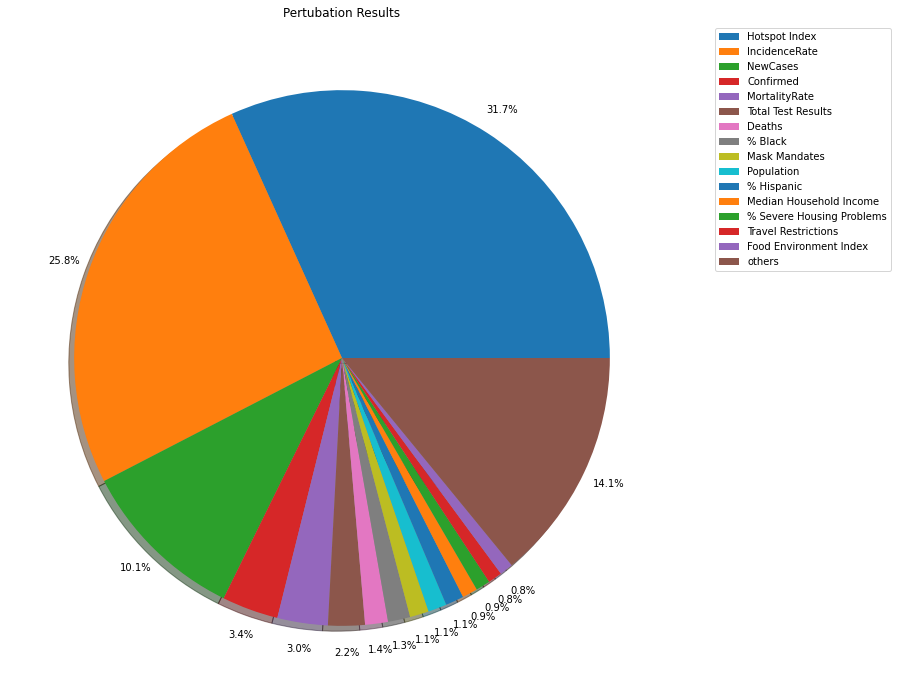

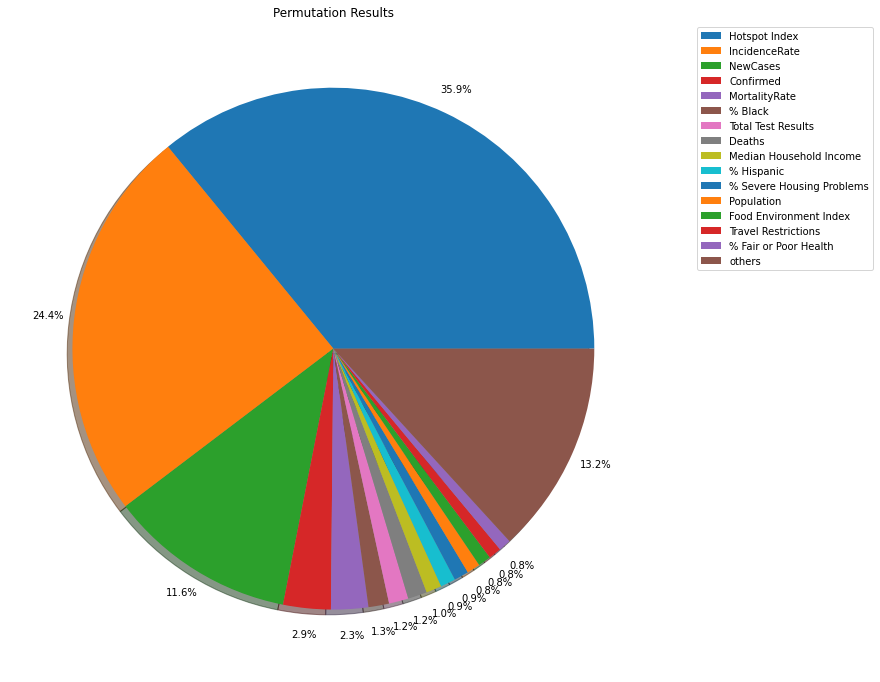

In [86]:
pert_s = pert/np.sum(pert)
perm_s = perm/np.sum(perm)

num = 15
plt.figure(figsize=(12,20))
plt.title('Pertubation Results')
plt.pie(([1-np.sum(pert_s[-num:])]+list(pert_s[-num:]))[::-1],labels=(['others']+list(df.columns.values[2:][pert_sort][-num:]))[::-1],shadow=True,autopct='%1.1f%%',labeldistance=None,pctdistance=1.1)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('pert_14_7_single.png')
plt.show();

plt.figure(figsize=(12,12))
plt.title('Permutation Results')
plt.pie(([1-np.sum(perm_s[-num:])]+list(perm_s[-num:]))[::-1],labels=(['others']+list(df.columns.values[2:][perm_sort][-num:]))[::-1],shadow=True,autopct='%1.1f%%',labeldistance=None,pctdistance=1.1)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('perm_14_7_single.png')
plt.show();

In [0]:
model.save('model_14_7_single.h5')

In [35]:
d= df['Hotspot Index']
d.mean(),d.median(),d.quantile(0.25),d.quantile(0.75),d.min(),d.max()

(1.7007837872072977, 0.0, 0.0, 2.7932152727983706, -0.002, 83.9943288245815)

In [48]:
#y_out = model.predict(x_val)
#_model = tf.keras.models.load_model('model_7_single')
temp = df[(df.dt > datetime(2020,5,6)) & (df.dt <= datetime(2020,5,20))][data_considered].groupby(['state','county'],as_index=False)
xv = []; yv = []; fips = []; _states=[]; _counties = []

for name,county in temp:
  # Normalize the training data
  if (len(county)!=14):
    continue
    # i = i
    # while 14-len(county) != 0:
    #   county = county.append(df[df.dt == datatime(2020,5,12)-timedelta(i)].loc[name,:])
    #   i+=1
  fips.append(county['FIPS'].values[0])
  _state, _county = name
  _states.append(_state); _counties.append(_county)
  county = county.drop(columns=['dt']).values.astype('float')

  # x_val_single, y_val_single = multivariate_data(county, county[:,-1],
  #                                             train_split, None, past_history,
  #                                             future_target, STEP,
  #                                             single_step=True)
  #print(x_train_single,y_train_single)
  xv.append([county])

xv = np.vstack(xv)
print(xv.shape)

y_out = model.predict((xv-county_mean)/county_std)
y_out = (y_out * y_std) + y_mean
print(y_out.shape)

prediction = pd.DataFrame({'FIPS':fips,'state': _states,'county':_counties, 'Hotspot Index': y_out.flatten()})
prediction.to_csv('prediction_5_27.csv',index=None)
#x_val = (x_val*county_std)+county_mean

(3105, 14, 46)
(3105, 1)


In [43]:
prediction.sort_values(by='Hotspot Index')

,FIPS,state,county,Hotspot Index
1933,35011,NM,De Baca,-0.015523
1293,26131,MI,Ontonagon,-0.009612
1091,21201,KY,Robertson,-0.009612
1837,31069,NE,Garden,-0.008339
1848,31091,NE,Hooker,-0.008085
...,...,...,...,...
913,20055,KS,Finney,2.473495
2194,40139,OK,Texas,2.477861
2469,47095,TN,Lake,2.481684
1821,31037,NE,Colfax,2.501177


In [127]:
__df = df[(df.dt > datetime(2020,5,12))]
print(__df.loc[('NJ','Somerset')])

                       dt  state_name  ...  % Positive  Hotspot Index
state county                           ...                           
NJ    Somerset 2020-05-13  New Jersey  ...       32.07       1.863170
      Somerset 2020-05-14  New Jersey  ...       31.59       1.873799
      Somerset 2020-05-15  New Jersey  ...       31.08       1.878395
      Somerset 2020-05-16  New Jersey  ...       30.53       1.886260
      Somerset 2020-05-17  New Jersey  ...       30.01       1.898180
      Somerset 2020-05-18  New Jersey  ...       29.28       1.899325
      Somerset 2020-05-19  New Jersey  ...       28.65       1.908416
      Somerset 2020-05-20  New Jersey  ...       28.31       1.915875
      Somerset 2020-05-21  New Jersey  ...       27.83       1.924313
      Somerset 2020-05-22  New Jersey  ...       27.50       1.927590
      Somerset 2020-05-23  New Jersey  ...       26.45       1.927570
      Somerset 2020-05-24  New Jersey  ...       25.53       1.934668
      Somerset 2020-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


In [7]:
df = pd.read_csv('data/jhu_covid19.csv',parse_dates=['dt'])
df.set_index(['state','county'],inplace=True)
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','# Asian'])
df['ColumnAmountNO2'] = df['ColumnAmountNO2']/1e15
df['ColumnAmountNO2CloudScreened'] = df['ColumnAmountNO2CloudScreened']/1e15
print(df)
df = df.groupby(['state','county']).bfill().ffill()
df = df.dropna(how='all')

target_name = 'Hotspot Index'
growth = df['Confirmed'].subtract(df['NewCases'],fill_value=0)
#print(len(df[df['NewCases']==0])/len(df))
growth_percentage = df['NewCases']/growth.replace({0:1})

df[target_name] = np.log(df['IncidenceRate']*0.004+df['MortalityRate']*0.004+growth_percentage*df['Confirmed']*0.001+1)
non_data = ['state_name']
data_considered = [column for column in df.columns if column not in non_data]
print(len(df[df[target_name]==0]))
print(df.columns)
print(df['FIPS'])
#df.to_csv('jhu_covid19.csv')

                      dt state_name  ...  Total Test Results  % Positive
state county                         ...                                
AL    Autauga 2020-01-22    Alabama  ...                   0        0.00
      Autauga 2020-01-23    Alabama  ...                   0        0.00
      Autauga 2020-01-24    Alabama  ...                   0        0.00
      Autauga 2020-01-25    Alabama  ...                   0        0.00
      Autauga 2020-01-26    Alabama  ...                   0        0.00
...                  ...        ...  ...                 ...         ...
WY    Weston  2020-05-23    Wyoming  ...                 244        4.06
      Weston  2020-05-24    Wyoming  ...                 244        4.06
      Weston  2020-05-25    Wyoming  ...                 249        4.11
      Weston  2020-05-26    Wyoming  ...                 262        3.95
      Weston  2020-05-27    Wyoming  ...                 262        3.95

[394445 rows x 47 columns]
217235
Index(['dt', 'st

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
print(df.sort_values(by=target_name)[target_name])

state  county      
TN     Shelby          -0.000680
NC     Mecklenburg     -0.000140
FL     Hillsborough    -0.000107
       Hillsborough    -0.000107
CA     Fresno          -0.000100
                         ...    
NY     Richmond        11.124906
       Bronx           13.215463
       Kings           13.585200
       Queens          13.937766
       New York              NaN
Name: Hotspot Index, Length: 394445, dtype: float64


In [28]:
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [0]:
# # These will usually be more like 32 or 64 dimensional.
# # We will keep them small, so we can see how the weights change as we train.
# EMBEDDING_DIM = 64
# HIDDEN_DIM = 64

# vocab_size = len(words)
# embedding_dim = 30
# embeds = nn.Embedding(l, 64)
# class LSTMTagger(nn.Module):

#     def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
#         super(LSTMTagger, self).__init__()
#         self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

#         # The LSTM takes word embeddings as inputs, and outputs hidden states
#         # with dimensionality hidden_dim.
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim)

#         # The linear layer that maps from hidden state space to tag space
#         self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

#     def forward(self, sentence):
#         embeds = self.word_embeddings(sentence)
#         lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
#         tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
#         tag_scores = F.log_softmax(tag_space, dim=1)
#         return tag_scores

# model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, l, 1)
# loss_function = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1)

# for epoch in range(20):  # again, normally you would NOT do 300 epochs, it is toy data
#     for sentence, tags in training_data:
#         # Step 1. Remember that Pytorch accumulates gradients.
#         # We need to clear them out before each instance
#         model.zero_grad()

#         # Step 2. Get our inputs ready for the network, that is, turn them into
#         # Tensors of word indices.
#         sentence_in = prepare_sequence(sentence, word_to_ix)
#         targets = prepare_sequence(tags, tag_to_ix)

#         # Step 3. Run our forward pass.
#         tag_scores = model(sentence_in)

#         # Step 4. Compute the loss, gradients, and update the parameters by
#         #  calling optimizer.step()
#         loss = loss_function(tag_scores, targets)
#         loss.backward()
#         optimizer.step()

# # See what the scores are after training
# with torch.no_grad():
#     inputs = prepare_sequence(training_data[0][0], word_to_ix)
#     tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    # print(tag_scores)
